Custom reward function with long term eplison

In [15]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def transform_action_values(n_actions, min_action=-2.0, max_action=2.0):
    linear_actions = np.linspace(-1, 1, n_actions)
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)
    scaled_actions = min_action + (non_linear_actions + 1) * (max_action - min_action) / 2
    return np.append(scaled_actions, [0]*(int(len(scaled_actions)*0.2)))

def reward_func(reward, custom_reward, EPOCHS):
    if reward < 0:
        custom_reward
    else:
        custom_reward = np.exp(custom_reward/25)

    if EPOCHS % 5 == 0:
        if reward > -10: 
            return custom_reward*2
        elif reward > -50:
            return custom_reward*1.5
        elif reward > -100:
            return custom_reward*1.2
        elif reward > -200:
            return custom_reward
        else:
            return custom_reward*0.8
    else:
        return custom_reward
    

# Define the Replay Buffer class
class PriorityReplayBuffer:
    def __init__(self, buffer_limit, alpha):
        self.buffer = []
        self.priorities = []
        self.buffer_limit = buffer_limit
        self.alpha = alpha
        self.pos = 0
        self.priorities_sum = 0

    def put(self, transition, priority):
        if len(self.buffer) < self.buffer_limit:
            self.buffer.append(transition)
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = transition
            self.priorities_sum -= self.priorities[self.pos]
            self.priorities[self.pos] = priority
        self.priorities_sum += priority
        self.pos = (self.pos + 1) % self.buffer_limit

    def sample(self, n, beta):
        scaled_priorities = [p ** self.alpha for p in self.priorities]
        sample_probs = [p / self.priorities_sum for p in scaled_priorities]
        sampled_indices = np.random.choice(len(self.buffer), n, p=sample_probs)
        
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in sampled_indices])
        weights = [(1 / (len(self.buffer) * sample_probs[i])) ** beta for i in sampled_indices]

        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones), np.array(weights), sampled_indices

    def update_priorities(self, indices, new_priorities):
        for idx, p in zip(indices, new_priorities):
            self.priorities_sum -= self.priorities[idx]
            self.priorities[idx] = p
            self.priorities_sum += p

    def size(self):
        return len(self.buffer)

# Define the Q-Network class
class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_values = transform_action_values(action_size)
        self.action_size = len(self.action_values)
        self.memory = PriorityReplayBuffer(buffer_limit=1000000, alpha=0.6)
        self.batch_size = 256
        self.tau = 0.01
        self.gamma = 0.9
        self.epsilon = 1
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.0001
        self.beta_start = 0.4
        self.beta_end = 1.0
        self.beta_increment_per_sampling = 0.001
        self.beta = self.beta_start
        self.learning_rate = 0.005
        self.model = DQNNetwork(state_size, self.action_size).to(device)
        self.target_model = DQNNetwork(state_size, self.action_size).to(device)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def select_action(self, state_tensor):
        if np.random.rand() > self.epsilon:
            action_index = torch.argmax(self.model(state_tensor)).item()
            action = self.action_values[action_index]
        else:
            action_index = np.random.randint(len(self.action_values))
            action = self.action_values[action_index]
        return action, action_index

    def store_experience(self, state, action, reward, next_state, done):
        max_priority = max(self.memory.priorities, default=1.0)
        # Store the experience with its priority
        self.memory.put((state, action, reward, next_state, done), max_priority)

    def train_agent(self):
        if self.memory.size() < self.batch_size:
            return

        self.beta = min(self.beta + self.beta_increment_per_sampling, self.beta_end)
        s_batch, a_batch, r_batch, s_prime_batch, done_batch, weights, indices = self.memory.sample(self.batch_size, self.beta)

        # Convert numpy arrays to PyTorch tensors and move them to the device
        s_batch = torch.tensor(s_batch, dtype=torch.float32).to(device)
        # Ensure a_batch is of dtype torch.int64 for use as an index
        a_batch = torch.tensor(a_batch, dtype=torch.int64).to(device).unsqueeze(1)
        r_batch = torch.tensor(r_batch, dtype=torch.float32).to(device).unsqueeze(1)
        s_prime_batch = torch.tensor(s_prime_batch, dtype=torch.float32).to(device)
        done_batch = torch.tensor(done_batch, dtype=torch.float32).to(device).unsqueeze(1)
        weights = torch.tensor(weights, dtype=torch.float32).to(device)

        # Calculate Q values and expected Q values
        q_values = self.model(s_batch).gather(1, a_batch)
        next_q_values = self.target_model(s_prime_batch).detach().max(1)[0].unsqueeze(1)
        expected_q_values = r_batch + self.gamma * next_q_values * (1 - done_batch)

        # Compute loss
        loss = F.smooth_l1_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # Soft update the target network
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)


Episodes 1/200, Score: -1007.0725246777268, CScore: -388.293071432979, Epsilion: 1
Episodes 2/200, Score: -1181.8265772250284, CScore: -445.5476237570373, Epsilion: 0.9856039041216536
Episodes 3/200, Score: -1571.1035284653353, CScore: -30.95625011851041, Epsilion: 0.9660866730744385
Episodes 4/200, Score: -1174.3403147651168, CScore: 354.95289928016524, Epsilion: 0.9469559282273666
Episodes 5/200, Score: -1312.0218887321096, CScore: 98.44991938774842, Epsilion: 0.9282040162620683
Episodes 6/200, Score: -1307.265468519262, CScore: 767.3187517353316, Epsilion: 0.9098234354135336
Episodes 7/200, Score: -1000.7680658893622, CScore: 499.58406555465467, Epsilion: 0.8918068324690056
Episodes 8/200, Score: -983.2402291468516, CScore: 320.09435129973053, Epsilion: 0.8741469998263031
Episodes 9/200, Score: -1440.3908967899606, CScore: 692.4963986851833, Epsilion: 0.8568368726103965
Episodes 10/200, Score: -1175.6861179933194, CScore: 636.2732945572149, Epsilion: 0.8398695258470806
Episodes 11/2

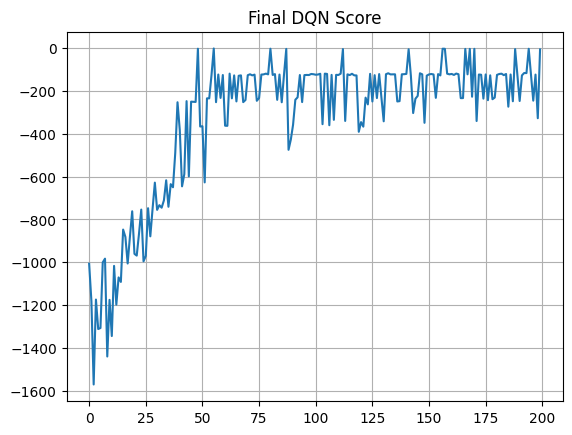

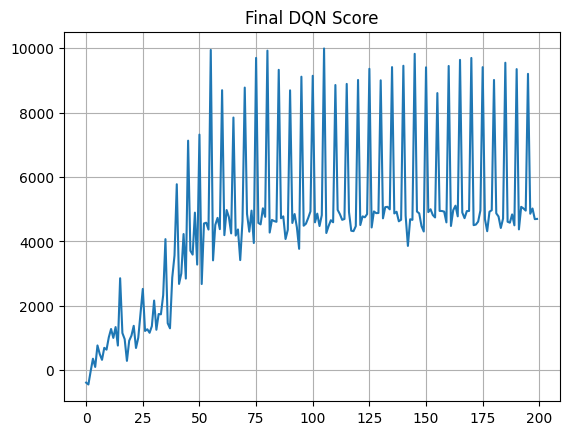

In [16]:
# Main training loop
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_size = 41

    agent = Agent(state_size, action_size)

    EPOCHS = 200
    custom_score_list = []
    score_list = []

    for EP in range(EPOCHS):
        state, info = env.reset()
        score = 0
        custom_score = 0
        done = False

        while not done:
            # Convert the state to a tensor and move it to the correct device
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            # Select an action based on the current state
            action, action_index = agent.select_action(state_tensor)

            # Perform the action in the environment
            next_state, reward, done, truncated, _ = env.step([action])
            custom_reward = 25 * np.exp(-1 * (next_state[0] - 1) ** 2 / 0.001) - 100 * np.abs(10 * 0.5 - (10 * 0.5 * next_state[0] + 0.5 * 0.3333 * next_state[2] ** 2)) + 100 * np.abs(10 * 0.5 - (10 * 0.5 * state[0] + 0.5 * 0.3333 * state[2] ** 2))
            custom_reward = reward_func(reward=reward, custom_reward=custom_reward, EPOCHS=EP)
            if done or truncated:
                done = True
            # Store the experience in the replay buffer
            agent.store_experience(state, action_index, custom_reward, next_state, done)
            # Train the agent
            agent.train_agent()

            # Update the state and accumulate the score
            state = next_state
            score += reward
            custom_score += custom_reward

        # Append the score of the EP to the list for plotting
        score_list.append(score)
        custom_score_list.append(custom_score)
        print(f"Episodes {EP + 1}/{EPOCHS}, Score: {score}, CScore: {custom_score}, Epsilion: {agent.epsilon}")

    plt.plot(score_list)
    plt.grid(True)
    plt.title("Final DQN Score")
    plt.show()

    plt.plot(custom_score_list)
    plt.grid(True)
    plt.title("Final DQN Score")
    plt.show()

In [17]:
def save_model(agent, filename="LEAD.pth"):
    checkpoint = {
        'model_state_dict': agent.model.state_dict(),
        'target_model_state_dict': agent.target_model.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'replay_buffer_experiences': agent.memory.buffer,
        'replay_buffer_priorities': agent.memory.priorities,
        'epsilon': agent.epsilon,
        'beta': agent.beta
    }
    torch.save(checkpoint, filename)
    print("Model saved!")

def load_model(agent, filename="LEAD.pth"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename, map_location=device)
        agent.model.load_state_dict(checkpoint['model_state_dict'])
        agent.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        agent.memory.buffer = checkpoint['replay_buffer_experiences']
        agent.memory.priorities = checkpoint['replay_buffer_priorities'] 
        agent.epsilon = checkpoint['epsilon']
        agent.beta = checkpoint['beta'] 
    else:
        print("No saved model found.")

In [18]:
save_model(agent)

Model saved!


In [20]:
import os
def evaluate_agent(env, agent, n_episodes=10):
    scores = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        score = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action, _ = agent.select_action(state_tensor)
            next_state, reward, done, truncated, _ = env.step([action])
            done = done or truncated
            state = next_state
            score += reward

        scores.append(score)

    return scores

# Load the model and evaluate
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_size = 41

    agent = Agent(state_size, action_size)
    load_model(agent)

    # Evaluate the agent
    scores = evaluate_agent(env, agent, n_episodes=100)
    average_score = sum(scores) / len(scores)
    print(f"Average Score over 100 episodes: {average_score}")

Average Score over 100 episodes: -142.9171564868761


In [21]:
if __name__ == "__main__":
    env = gym.make('Pendulum-v1', render_mode='human')
    state_size = env.observation_space.shape[0]
    action_size = 41

    agent = Agent(state_size, action_size)
    load_model(agent)

    # Evaluate the agent
    evaluate_agent(env, agent, n_episodes=5)
    env.close()

Retrained with different reward

In [23]:
class PriorityReplayBuffer:
    def __init__(self, buffer_limit, alpha):
        self.buffer = []
        self.priorities = []
        self.buffer_limit = buffer_limit
        self.alpha = alpha
        self.pos = 0
        self.priorities_sum = 0

    def put(self, transition, priority):
        if len(self.buffer) < self.buffer_limit:
            self.buffer.append(transition)
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = transition
            self.priorities_sum -= self.priorities[self.pos]
            self.priorities[self.pos] = priority
        self.priorities_sum += priority
        self.pos = (self.pos + 1) % self.buffer_limit

    def sample(self, n, beta):
        scaled_priorities = [p ** self.alpha for p in self.priorities]
        total = sum(scaled_priorities)
        sample_probs = [p / total for p in scaled_priorities]  # Normalize probabilities
        sampled_indices = np.random.choice(len(self.buffer), n, p=sample_probs)
        
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in sampled_indices])
        weights = [(1 / (len(self.buffer) * sample_probs[i])) ** beta for i in sampled_indices]

        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones), np.array(weights), sampled_indices

    def update_priorities(self, indices, new_priorities):
        for idx, p in zip(indices, new_priorities):
            self.priorities_sum -= self.priorities[idx]
            self.priorities[idx] = p
            self.priorities_sum += p

    def size(self):
        return len(self.buffer)
    
def reward_func(reward, past_reward):
    value = (reward + past_reward)/2
    if value > -10: 
        return value*0.1
    elif value > -50:
        return value*0.7
    elif value > -100:
        return value*0.8
    elif value > -200:
        return value*0.9
    else:
        return value*1.2

Episodes 1/25, Score: -339.8825582733448, CScore: -77.72335447862763, Epsilion: 0.01841297429144631
Episodes 2/25, Score: -126.4521911485033, CScore: -50.7006188096522, Epsilion: 0.01804835492253985
Episodes 3/25, Score: -123.67905069220099, CScore: -50.33861883747486, Epsilion: 0.01769095585829883
Episodes 4/25, Score: -123.03659725133632, CScore: -50.40960849045563, Epsilion: 0.017340634120034
Episodes 5/25, Score: -117.22883680922433, CScore: -40.62087893348114, Epsilion: 0.016997249560363914
Episodes 6/25, Score: -230.82837633430015, CScore: -64.7716282059644, Epsilion: 0.016660664807148628
Episodes 7/25, Score: -118.96250180209496, CScore: -42.10743529492753, Epsilion: 0.016330745208533483
Episodes 8/25, Score: -234.6325822759325, CScore: -67.97892974485171, Epsilion: 0.016007358779081153
Episodes 9/25, Score: -234.39126188345864, CScore: -65.44880646520292, Epsilion: 0.01569037614697052
Episodes 10/25, Score: -116.07294436265074, CScore: -31.42883514908787, Epsilion: 0.0153796705

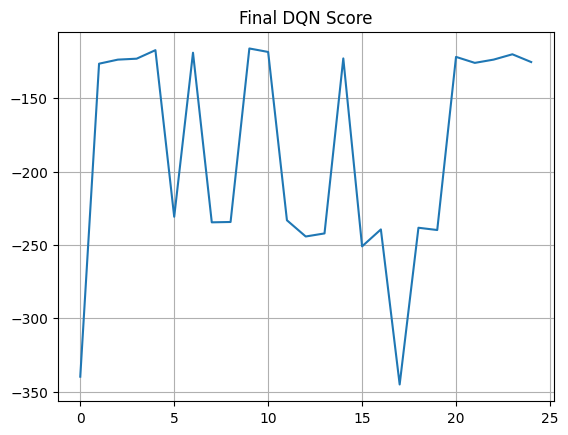

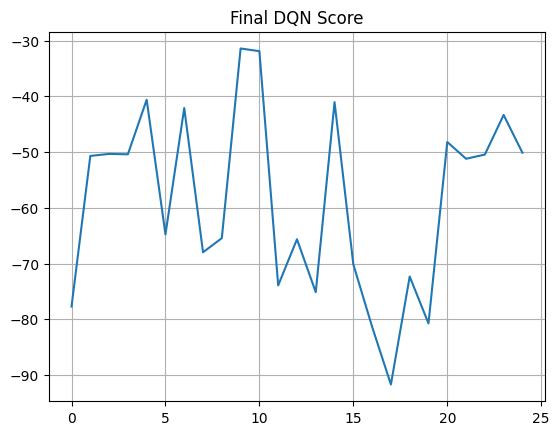

In [24]:
if __name__ == "__main__":
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_size = 41

    agent = Agent(state_size, action_size)
    load_model(agent, filename='LEAD.pth')

    EPOCHS = 25
    custom_score_list = []
    score_list = []

    for EP in range(EPOCHS):
        state, info = env.reset()
        score = 0
        custom_score = 0
        done = False
        past_reward = 0

        while not done:
            # Convert the state to a tensor and move it to the correct device
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            # Select an action based on the current state
            action, action_index = agent.select_action(state_tensor)

            # Perform the action in the environment
            next_state, reward, done, truncated, _ = env.step([action])
            custom_reward = reward_func(reward, past_reward)
            if done or truncated:
                done = True
            # Store the experience in the replay buffer
            agent.store_experience(state, action_index, custom_reward, next_state, done)
            # Train the agent
            agent.train_agent()

            # Update the state and accumulate the score
            state = next_state
            score += reward
            custom_score += custom_reward
            past_reward = reward
        # Append the score of the EP to the list for plotting
        score_list.append(score)
        custom_score_list.append(custom_score)
        print(f"Episodes {EP + 1}/{EPOCHS}, Score: {score}, CScore: {custom_score}, Epsilion: {agent.epsilon}")

    plt.plot(score_list)
    plt.grid(True)
    plt.title("Final DQN Score")
    plt.show()

    plt.plot(custom_score_list)
    plt.grid(True)
    plt.title("Final DQN Score")
    plt.show()

In [25]:
save_model(agent, filename="prb3_dqn_model.pth")

Model saved!


In [34]:
if __name__ == "__main__":
    overall_score= 0
    num_run = 10
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    action_size = 41

    agent = Agent(state_size, action_size)
    load_model(agent, filename="prb3_dqn_model.pth")

    # Evaluate the agent
    for _ in range(num_run):
        scores = evaluate_agent(env, agent, n_episodes=100)
        average_score = sum(scores) / len(scores)
        overall_score += average_score
        print(f"Average Score over 100 episodes: {average_score}")
    print(f"Total average {overall_score/num_run}")

Average Score over 100 episodes: -132.59051566442656
Average Score over 100 episodes: -141.12977369323332
Average Score over 100 episodes: -142.76919478787875
Average Score over 100 episodes: -146.89892817891666
Average Score over 100 episodes: -145.61129320664332
Average Score over 100 episodes: -155.68573910374715
Average Score over 100 episodes: -138.9090042342981
Average Score over 100 episodes: -136.71088465412132
Average Score over 100 episodes: -148.67474311936905
Average Score over 100 episodes: -148.50093965010734
Total average -143.74810162927415


In [33]:
if __name__ == "__main__":
    env = gym.make('Pendulum-v1', render_mode='human')
    state_size = env.observation_space.shape[0]
    action_size = 41

    agent = Agent(state_size, action_size)
    load_model(agent, filename="prb3_dqn_model.pth")

    # Evaluate the agent
    evaluate_agent(env, agent, n_episodes=5)
    env.close()